UFRJ/EQ, Agosto de 2018,
(updated @ 19 de Junho de 2019).

# Cálculo de equilíbrio líquido-vapor de substância pura com equação de estado cúbica.

iuri segtovich

# Introdução

O objetivo dessa aula é apresentar uma metodologia de resolução computacional de equação de estado cúbica.

> Por resolução, entendamos (1) cálculo de pressão a partir de volume e temperatura, (2) cálculo de volume a partir de pressão e temperatura e (3) cálculo de propriedades residuais (entalpia, entropia, energia de Helmholtz, energia de Gibbs).

Além disso, é apresentada uma metodologia para o cálculo de equilíbrio líquido vapor a partir do critério de igualdade de potencial químico do componente em cada fase.

> O critério de equlíbrio é satisfeito utilizando os cálculos de energia de Gibbs residual a partir da equação de estado.

Esta aula se limita ao estudo de substâncias puras.

> São estudadas a relação $P,V,T$ de substância pura em estado líquido ou vapor e em equilíbrio de fases, e a curva univariante de pressão de saturação.

Os cálculos que seguem são realizados utilizado a equação de estado cúbica de Soave para a substância Metano.

> São utilizados o equacionamento e parâmetros apresentados por Reid, Prausnitz & Poling, 1987 e por Smith, van Ness & Abbott, 2007.

>* Vamos trabalhar apenas com propriedades intensivas, portanto convém usar a notação simplificada: $P$ para pressão, $T$ para temperatura, $V$, $H$, $S$, $A$ e $G$ para volume molar, entalpia molar, entropia molar, energia de Helmholtz molar e energia de Gibbs molar.

# Metodologia

Essa aula é dividida nas seguintes etapas:

1. programação $P(T,V)$ usando a equação de Soave (Reid, Prausnitz & Poling, 1987 - pp 42, 43)
  1. cálculo em sequência de $P$ versus sequência de $V$ para dados $T$
  1. desenhar isotermas no plano $P$ versus $V$
1. programação $V(P,T)$ usando método de solução de raiz de polinômios (numpy.roots)
  1. implementar lógica de classificação de raízes de volume (líquido, vapor, intermediária e não física)
  1. comparar calculos pontuais com as isotermas
1. programação de pressão limite superior e inferior para cálculo de equilibrio de fases (baseado em Topliss, Dimitrelis & Prausnitz, 1988)
  1. comparar calculos pontuais com as isotermas
1. programação de energia de gibbs residual (Reid, Prausnitz & Poling, 1987)
  1. cálculo em sequência $G^{\mathrm{RES},L}$ e sequência $G^{\mathrm{RES},V}$ versus sequência $P$ para dado $T$
  1. desenhar $G^{\mathrm{RES},L}$ e $G^{\mathrm{RES},V}$ versus $P$ para dado $T$ e verificar existência de solução para o critério de equilíbrio de fases.
1. programação de resolução da pressão de saturação usando método de bisseção (scipy.optimize.bisect)
    1. cálculo em sequência de pressão de saturação versus sequência de $T$
    1. desenhar $P^\mathrm{SAT}$ versus $T$
1. geração do envelope de fases no plano $P$ versus $V$ (Smith, van Ness & Abbott, 2007)
    1. cálculo em sequência de volumes de líquido e olume de vapor para cada par $(T,P)$ na curva de $P^\mathrm{SAT}$
    1. desenhar envelope de fases no diagrama $P$ versus $V$ com algumas isotermas
1. programação de entalpia e entropia residuais (Reid, Prausnitz & Poling, 1987) - TAREFA
    1. testar pontualmente
1. geração dos envelope de fases nos planos $T$ versus $S^\mathrm{RES}$ e $P$ versus $H^\mathrm{RES}$ (Smith, van Ness & Abbott, 2007)
    1. cálculo em sequência de entalpia e entropia residuais de líquido e de vapor para cada par $(T,P)$ na curva de $P^\mathrm{SAT}$
    1. desenhar envelope de fases no diagrama T versus $S^\mathrm{RES}$ com algumas isóbaras
    1. desenhar envelope de fases no diagrama P versus $H^\mathrm{RES}$ com algumas isotermas

## carregando pacotes utilizados nesta aula:

In [1]:
import numpy as np
#1. arrays (vetores R^n) para cálculos em sequência
#2. resolução de raiz de polinômios (np.roots)

from matplotlib import pyplot as plt
# pacote para desenhar gráficos

from scipy import optimize as opt
# resolução de equação não linear por método de biseção (opt.bisect)

# Implementação, resultados e discussão

## A equação de Soave
é uma equação de estado dada pela expressão de pressão em função de temperatura e volume molar abaixo

$$P=\frac{RT}{V-b}-\frac{a}{V^2+ubV+wb^2}$$

em que

> $u=1$
>
> $w=0$
>
> $b=\frac{0.08664RT_c}{P_c}$
>
> $a=\frac{0.42748R^2T_c^2}{P_c}(1+f(1-(T/T_c)^{(1/2)}))^2$
>
>$f=0.48+1.574\omega-0.176\omega^2$

> Reid, Prausnitz & Poling, 1987 pp 42, 43

Nota-se que sua parametrização ($a$,$b$) é dada em função de propriedades do componente (temperatura crítica - $T_c$, pressão crítica - $P_c$, e o fator acêntrico de Pitzer - $\omega$ )

Os parâmetros $u$ e $w$ servem para representar a equação de Soave na forma geral em que também se encaixam as equações de van der Waals; Redlich e Kwong; e Peng e Robinson utilizada por Reid, Prausnitz e Poling, 1987.

> Abaixo são dadas as propriedades para o metano
> (Smith, van Ness & Abbott, 2007, pp 632, 633)

In [2]:
Tc= 190.6 #K
Pc= 45.99e5 #Pa
omega= 0.012 #fator acêntrico, adimensional

Aqui é definida como constante global do roteiro de cálculo da aula a constante de gases $R$ em unidades do sistema internacional S.I.

In [3]:
R=8.314 #S.I.

Aqui é implementada a equação de estado apresentada
> A implementação é feita como uma função de temperatura e volume molar retornando pressão,
>
> Essa equação conta com constantes ou parâmetros globais $R$, $a$ e $b$
>
> Notemos que o parâmetro $a$ da equação de Soave depende da temperatura, dessa forma faremos a implementação desse parâmetro como uma função global `func_a(T)`

In [4]:
def func_P_soave(T,Vm):
    a=func_a(T=T)
    return R*T/(Vm-b) - a/(Vm**2 + u*b*Vm + w*b**2)

# Soave
u=1
w=0

b=(0.08664*R*Tc)/Pc
ac=0.42748*R**2*Tc**2/Pc

def func_a(T):
    Tr=T/Tc
    return ac*(1+f_omega*(1-Tr**(.5)))**2

f_omega = 0.48 + 1.574*omega-0.176*omega**2

## Cálculo

* testes

Podemos arbitrar valores de temperatura e volume molar para verificar se a função retorna valores coerentes

In [5]:
Ptest=func_P_soave(T=170,Vm=b*1.01)
print( Ptest)

4598201536.582451


* vetorizado

Aqui definimos array (vetor $\mathbb{R}^n$) contendo uma sequência finita de valores arbitrados para volume molar

> vamos usar um array de tamanho 100 para termos uma quantidade tal de valores calculados que possamos apreciá-la em um gráfico

Realizaremos o cálculo de pressão para cada elemento do array de volume molar, resultando em um array de valores calculados para pressão em data temperatura.

In [6]:
Ttest=170.
nV=100
minV=b*1.01
maxV=1e-1
seqVm= np.logspace(np.log10(minV),np.log10(maxV),nV)
print( "Vm:", seqVm )

seqP=np.zeros(nV)
for i in range(nV):
    seqP[i]=func_P_soave(T=Ttest,Vm=seqVm[i])

print( "P:", seqP )

Vm: [3.01515279e-05 3.27244123e-05 3.55168457e-05 3.85475624e-05
 4.18368957e-05 4.54069138e-05 4.92815679e-05 5.34868533e-05
 5.80509834e-05 6.30045789e-05 6.83808736e-05 7.42159374e-05
 8.05489177e-05 8.74223026e-05 9.48822060e-05 1.02978676e-04
 1.11766033e-04 1.21303231e-04 1.31654256e-04 1.42888552e-04
 1.55081490e-04 1.68314875e-04 1.82677488e-04 1.98265688e-04
 2.15184058e-04 2.33546104e-04 2.53475016e-04 2.75104497e-04
 2.98579662e-04 3.24058005e-04 3.51710462e-04 3.81722552e-04
 4.14295628e-04 4.49648224e-04 4.88017522e-04 5.29660940e-04
 5.74857867e-04 6.23911529e-04 6.77151030e-04 7.34933553e-04
 7.97646764e-04 8.65711406e-04 9.39584127e-04 1.01976054e-03
 1.10677856e-03 1.20122197e-03 1.30372442e-03 1.41497358e-03
 1.53571584e-03 1.66676125e-03 1.80898901e-03 1.96335332e-03
 2.13088981e-03 2.31272249e-03 2.51007129e-03 2.72426022e-03
 2.95672627e-03 3.20902908e-03 3.48286134e-03 3.78006020e-03
 4.10261959e-03 4.45270354e-03 4.83266080e-03 5.24504049e-03
 5.69260929e-03 6.17

* plot

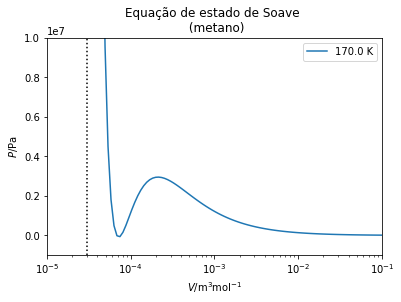

In [7]:
plt.plot(seqVm,seqP,label=str(Ttest)+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
plt.axvline(b,color='black',ls=":")
plt.ylabel(r'$P / \mathrm{Pa}$') #create labels to be displayed in y axis of the plot
plt.xlabel(r'${V} / \mathrm{m^{3}mol^{-1}}$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Equação de estado de Soave \n (metano)') #create a title for the figure
plt.ylim(-1e6,1e7)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
plt.xlim(1e-5,1e-1) #define max and min limits of the x axis
plt.xscale('log')
plt.legend()
plt.show()

## V eos

A equação de estado de Soave é dita cúbica pois pode ser re-escrita da seguinte forma:

$$Z^3-Z^2(1+B-uB)+Z(A+wB^2-uB-uB^2)-AB-wB^2-wB^3=0$$

> Reid, Prausnitz & Poling, 1987, pp 42, 43

Que é um polinômia de grau 3 (equação cúbica) na variável Z

em que 

$$Z=\frac{PV}{RT}$$

Vamos implementar essa forma polinomial e resolver usando um método de solução de polinômios


In [8]:
def func_VL_VV_cubic(T,P):
    a=func_a(T=T)
    A=a*P/(R**2*T**2)
    B=b*P/(R*T)
    
    c3=1 
    c2=-(1+B-u*B)
    c1=(A+w*B**2-u*B-u*B**2)
    c0=-A*B-w*B**2-w*B**3
    
    list_coeffs=[c3,c2,c1,c0]

    Z1,Z2,Z3=np.roots(list_coeffs) #Como c3=1, nunca vai vir menos de três raízes (incluindo real e complexa)
    
    V1=Z1*R*T/P
    V2=Z2*R*T/P
    V3=Z3*R*T/P
        
    imag_tol = 1e-11

    listVphysical=[]
    
    for V in [V1,V2,V3]:
        if (abs(V.imag) < imag_tol) and (V.real > b): #condicao para existencia de um valor real
            listVphysical.append(V.real)
    nVphysical = len(listVphysical)
    vL=min(listVphysical) #se shouver apenas um V físico a função vai retornar valores de Volume iguais para liq e vap
    vV=max(listVphysical) 
    
    return vL, vV, nVphysical

vL, vV, nVphys
6.0569366601097504e-05 0.0012560729664867032 3


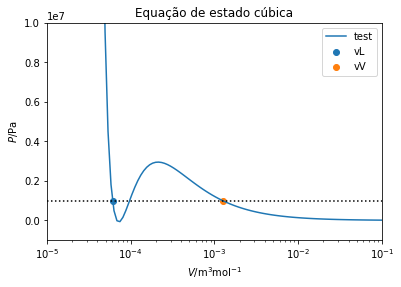

In [9]:
Ptest=1e6
vL, vV, nVphys  = func_VL_VV_cubic(T=Ttest,P=Ptest)
print ("vL, vV, nVphys")     
print(vL, vV, nVphys)    
    
plt.plot(seqVm,seqP,label='test') 
plt.scatter(vL,Ptest,label="vL") 
plt.scatter(vV,Ptest,label="vV") 
plt.axhline(Ptest,color='black',ls=':')

plt.xlabel(r'${V} / \mathrm{m^{3}mol^{-1}}$')
plt.ylabel(r'$P / \mathrm{Pa}$')
plt.title('Equação de estado cúbica') 
plt.ylim(-1e6,1e7)
plt.xlim(1e-5,1e-1) 
plt.xscale('log')
plt.legend()
plt.show()  

# Faixa de busca para pressão de saturação
(metodologia baseada em Topliss, Dimitrelis & Prausnitz, 1988)

Sabendo que a pressão de saturação está na faixa de pressão para a qual há três raízes de volume, a região de busca pode ser definida pelo cálculo do mínimo e máximo locais da isoterma:

dado $T$, buscar $V^*$ tal que $\left(\frac{\partial P}{\partial V}\right)_T=0$

Filtram-se apenas os valores físicos: $V^*$ entre $b$ e $\infty$

$$ \left( \frac{\partial P}{\partial V} \right) _T= 0$$

usando a equação de Soave, obtemos a seguinte expressão para essa derivada parcial

$$\frac{\partial{P}}{\partial{V}} = - \frac{R T}{\left(V - b\right)^{2}} - \frac{a \left(- 2 V - b u\right)}{\left(V^{2} + V b u + b^{2} w\right)^{2}}$$

como buscamos os valores de V para os quais a expressão dá zero, podemos multiplicar ambos os lados da equação pelos denominadores de cada termo, obtendo assim

$$- R T \left(V^{2} + V b u + b^{2} w\right)^{2} - a \left(- 2 V - b u\right) \left(V - b\right)^{2} = 0$$

realizando as operações distributivas, potências de somas e coletando os coeficientes de iguais potências de V chegamos a representação polinomial

$$V^{4} - \frac{V^{3}}{R T} \left(- 2 R T b u + 2 a\right) - \frac{V^{2}}{R T} \left(- R T b^{2} u^{2} - 2 R T b^{2} w + a b u - 4 a b\right) - \frac{V}{R T} \left(- 2 R T b^{3} u w - 2 a b^{2} u + 2 a b^{2}\right) - \frac{1}{R T} \left(- R T b^{4} w^{2} + a b^{3} u\right) = 0$$

A qual pode ser convenientemente expressa por coeficientes $c_0$, $c_1$, $c_2$, $c_3$ e $c_4$.

$$ c_4V^4 + c_3 V^3+c_2V^2+c_1 V+c_0=0$$

em que

$c_4 = 1$

$c_3 = (-2RTbu + 2a)/(-RT)$

$c_2 = (-RTb^2u^2 - 2RTb^2w + abu - 4ab)/(-RT)$

$c_1 = (-2RTb^3uw - 2ab^2u + 2ab^2)/(-RT)$

$c_0 = (-RTb^4w^2 + ab^3u)/(-RT)$

In [10]:
def func_Plimits(T):
    #cálculo dos limites para busca de pressão de saturação
    
    #calcular coeficientes da representação polinomial
    a=func_a(T=T)
    
    c4 = 1
    c3 = (-2*R*T*b*u + 2*a)/(-R*T)
    c2 = (-R*T*b**2*u**2 - 2*R*T*b**2*w + a*b*u - 4*a*b)/(-R*T)
    c1 = (-2*R*T*b**3*u*w - 2*a*b**2*u + 2*a*b**2)/(-R*T)
    c0 = (-R*T*b**4*w**2 + a*b**3*u)/(-R*T)
    
    #resolver raízes com a função roots
    list_coeffs=[c4,c3,c2,c1,c0]

    V1,V2,V3,V4=np.roots(list_coeffs) #Como c4=1, nunca vai vir menos de quatro raízes (incluindo real e complexa)
    
    imag_tol = 1e-11

    listVphysical=[]
    
    for V in [V1,V2,V3,V4]:
        if (abs(V.imag) < imag_tol) and (V.real > b): #condicao para existencia de um valor real
            listVphysical.append(V.real)
    nVphysical = len(listVphysical)
    
    if nVphysical >= 1:
        Vinfi = min(listVphysical)
        Vsupi = max(listVphysical)
    
    
        #calcular a pressão correspondente a cada raiz de volume selecionada
        Psupi = func_P_soave(T=T,Vm=Vsupi)
        Pinfi = func_P_soave(T=T,Vm=Vinfi)
            
    elif nVphysical==0:
        #não achamos faixa de busca
        Vli=None
        Vvi=None
        Psupi=None
        Pinfi=None
        
    return Vinfi,Vsupi,Pinfi,Psupi,nVphysical

In [11]:
Vinfilim,Vsupilim,Pinfilim,Psupilim,nPlim=func_Plimits(T=Ttest)
print("Ttest:",Ttest)
print("nPlim:",nPlim)
print("Vli:",Vinfilim)
print("Vvi:",Vsupilim)
print("Pinfi:",Pinfilim)
print("Psupi:",Psupilim)

Ttest: 170.0
nPlim: 2
Vli: 7.185706757128375e-05
Vvi: 0.00021160358619134282
Pinfi: -83359.0781999901
Psupi: 2951301.4168593585


* validação gráfica

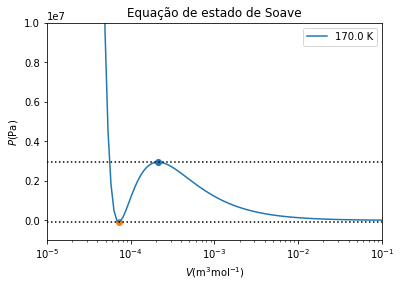

In [12]:
plt.semilogx(seqVm,seqP,label=str(Ttest)+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
plt.ylabel(r'$P (\mathrm{Pa})$') #create labels to be displayed in y axis of the plot
plt.xlabel(r'${V} (\mathrm{m^{3}mol^{-1}})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Equação de estado de Soave') #create a title for the figure
plt.ylim(-1e6,1e7)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
plt.xlim(1e-5,1e-1) #define max and min limits of the x axis
if nPlim>0:
    plt.scatter(Vsupilim,Psupilim)
    plt.axhline(Psupilim,color='black',ls=':')
    plt.scatter(Vinfilim,Pinfilim)
    plt.axhline(Pinfilim,color='black',ls=':')
plt.legend()
plt.show()

## G residual

$$A^{\mathrm{RES}} = - R T \ln{\left (\frac{V}{V^{IG}} \right )} - R T \ln{\left (\frac{1}{Z} \left(- B + Z\right) \right )} + \frac{a}{b \sqrt{u^{2} - 4 w}} \ln{\left (\frac{B \left(u - \sqrt{u^{2} - 4 w}\right) + 2 Z}{B \left(u + \sqrt{u^{2} - 4 w}\right) + 2 Z} \right )}$$

> Reid, Prausnitz & Poling, 1987, pp 102

logo, como $G = A+PV$

temos que $G^{IG} = A^{IG}+PV^{IG}$

logo

$$G^\mathrm{RES} = A^\mathrm{RES}+P(V-V^{IG})$$

$$G^{\mathrm{RES}} = R T (Z-1) - R T \ln{\left ( - B + Z \right )} + \frac{a}{b \sqrt{u^{2} - 4 w}} \ln{\left (\frac{B \left(u - \sqrt{u^{2} - 4 w}\right) + 2 Z}{B \left(u + \sqrt{u^{2} - 4 w}\right) + 2 Z} \right )}$$



In [13]:
def func_Gres_RT(T,P,Z):    
    a=func_a(T)
    A=a*P/(R**2*T**2)
    B=b*P/(R*T)
    T1=A/(B*(u**2-4*w)**.5)
    T2=(-1)
    T3=2*Z+B*(u+(u**2-4*w)**.5)
    T4=2*Z+B*(u-(u**2-4*w)**.5)
    Gres_RT_TPZ = (Z-1)-np.log(Z-B)+T1*T2*np.log(T3/T4)
    return Gres_RT_TPZ

## o critério de equilíbrio

$$\mu_i^L=\mu_i^V$$

no caso do puro, $G=\mu_i$

$$G^\mathrm{L}=G^\mathrm{V}$$

usando uma mesma referência

$$G^\mathrm{L}-G^\mathrm{IG}=G^\mathrm{V}-G^\mathrm{IG}$$

$$ G^\mathrm{RES,L}=G^\mathrm{RES,V} $$

ou com as variáveis adimensionadas dividinto pelo produto $(RT)$

$$ \frac{G^\mathrm{RES,L}}{RT}=\frac{G^\mathrm{RES,V}}{RT} $$

* verificar existẽncia de solução em uma temperatura teste

In [14]:
Vinfi,Vsupi,Pinfi,Psupi,nVlim=func_Plimits(Ttest)

nP=100
Gres_RT_L=np.zeros(nP)
Gres_RT_V=np.zeros(nP)

Psupi=Psupi*.999999

if Pinfi > 0:
    Pinfi = Pinfi*1.000001
else:
    Pinfi = Psupi/1e10 

seqP2 = np.linspace(Pinfi,Psupi,nP)
Vmi_L=np.zeros(nP)
Vmi_V=np.zeros(nP)
Z_L=np.zeros(nP)
Z_V=np.zeros(nP)
nV=np.zeros(nP)
for i in range(nP):
    Vmi_L[i],Vmi_V[i],nV[i] = func_VL_VV_cubic(T=Ttest,P=seqP2[i])
    Z_L[i]=(seqP2[i]*Vmi_L[i])/(R*Ttest)
    Z_V[i]=(seqP2[i]*Vmi_V[i])/(R*Ttest)
    Gres_RT_L[i] = func_Gres_RT(T=Ttest,P=seqP2[i],Z=Z_L[i])
    Gres_RT_V[i] = func_Gres_RT(T=Ttest,P=seqP2[i],Z=Z_V[i])

* plot

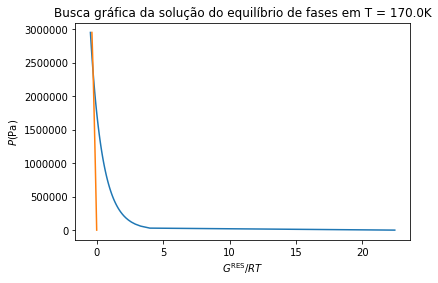

In [15]:
plt.plot(Gres_RT_L,seqP2)
plt.plot(Gres_RT_V,seqP2)

plt.xlabel(r'$G^\mathrm{RES}/RT$') #create labels to be displayed in y axis of the plot
plt.ylabel(r'$P (\mathrm{Pa})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Busca gráfica da solução do equilíbrio de fases em T = '+str(Ttest)+'K') #create a title for the figure

plt.show()

## Pressão de saturação

In [16]:
def func_Psat(T):
    
    def func_RES(P):
        VL,VV,nV=func_VL_VV_cubic(T=T,P=P)
        ZL=VL*P/(R*T)
        ZV=VV*P/(R*T)
        Gres_RT_L=func_Gres_RT(T=T,P=P,Z=ZL)
        Gres_RT_V=func_Gres_RT(T=T,P=P,Z=ZV)
        return Gres_RT_L-Gres_RT_V

    Vinfi,Vsupi,Pinfi,Psupi,nlim=func_Plimits(T=T)
    
    #definir com limite superior uma pressão ligeiramente abaixo da pressão limite superior
    #e ligeiramente acima da pressão limite inferior para garantir que existam três volumes nas condições teste
    #não levar pressão negativa para o cálculo de pressão de saturação
    Psupi=Psupi*.999999

    if Pinfi > 0.:
        Pinfi = Pinfi*1.000001
    else:
        Pinfi = Psupi/1e10
    
    P0a=Pinfi
    P0b=Psupi
    
    Psati = opt.bisect(func_RES,P0a,P0b)
    
    return Psati

Psat_test = func_Psat(T=Ttest)
print('Ttest,Psat_test')
print(Ttest,Psat_test)

Ttest,Psat_test
170.0 2358783.478269603


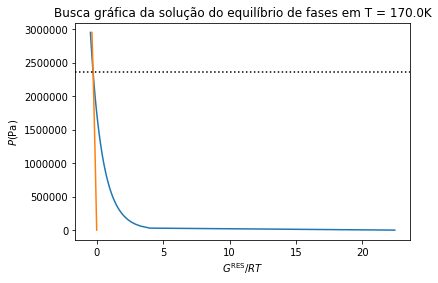

In [17]:
plt.plot(Gres_RT_L,seqP2)
plt.plot(Gres_RT_V,seqP2)
plt.axhline(Psat_test,color='k',ls=":")

plt.xlabel(r'$G^\mathrm{RES}/RT$') #create labels to be displayed in y axis of the plot
plt.ylabel(r'$P (\mathrm{Pa})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Busca gráfica da solução do equilíbrio de fases em T = '+str(Ttest)+'K') #create a title for the figure

plt.show()

* cálculo em sequência

In [18]:
nPsat=100
seqT3=np.linspace(Tc/3,Tc*.99,nPsat)
seqP3=np.zeros(nPsat)
for i in range(nPsat):
    seqP3[i]=func_Psat(seqT3[i])

* plot

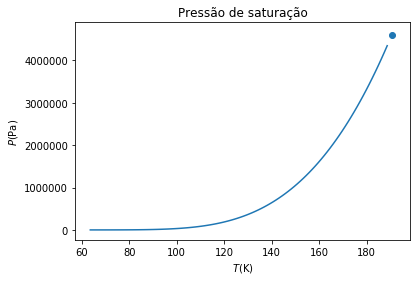

In [19]:
plt.plot(seqT3,seqP3)
plt.scatter(Tc,Pc)
# plt.yscale('log')

plt.xlabel(r'$T(\mathrm{K})$') #create labels to be displayed in y axis of the plot
plt.ylabel(r'$P (\mathrm{Pa})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Pressão de saturação') #create a title for the figure

plt.show()

# Implementação inversa:
$T^{\mathrm{SAT}}(P)$

In [20]:
def func_Tsat(P):
    
    def func_RES(T):
        return func_Psat(T=T)-P

    Tsati = opt.fsolve(func_RES,.99*Tc)[0]
    
    return Tsati

Tsat_test = func_Tsat(P=Psat_test)
print('Ttest,Psat_test,Tsat_test')
print(Ttest,Psat_test,Tsat_test)

Ttest,Psat_test,Tsat_test
170.0 2358783.478269603 170.0000000000002


## testando

In [21]:
for Psat_test_i in np.linspace(100,.99*Pc):
    print( Psat_test_i/Pc, func_Tsat(P=Psat_test_i) )

2.1743857360295716e-05 65.87815000333453
0.02022538173782233 111.04064722836088
0.040429019618284365 119.85697842156218
0.0606326574987464 125.74426749210231
0.08083629537920843 130.30405322010583
0.10103993325967048 134.08442727446118
0.1212435711401325 137.34471579858075
0.14144720902059454 140.22993409758655
0.16165084690105658 142.830098467092
0.18185448478151858 145.20525709008032
0.20205812266198064 147.39764146058351
0.22226176054244268 149.43818145365526
0.2424653984229047 151.35026891775107
0.26266903630336674 153.1520622267862
0.2828726741838288 154.85796511753568
0.3030763120642908 156.4796129673316
0.32327994994475284 158.0265521705809
0.3434835878252149 159.50672115392467
0.3636872257056769 160.92679910669509
0.38389086358613894 162.29246407270404
0.404094501466601 163.6085874531978
0.424298139347063 164.87938295937676
0.44450177722752504 166.10852232682012
0.4647054151079871 167.2992263715855
0.4849090529884491 168.4543374791239
0.5051126908689112 169.57637792259987
0.525

## envelope

In [22]:
VL_seq=np.zeros(nPsat)
VV_seq=np.zeros(nPsat)
nV_seq=np.zeros(nPsat)
for i in range(nPsat):
    VL_seq[i],VV_seq[i],nV_seq[i]=func_VL_VV_cubic(T=seqT3[i],P=seqP3[i])

In [23]:
vl,vv,n = func_VL_VV_cubic(T=Tc,P=Pc)
print(vl,vv,n)
vc=vv

0.00011275026723619101 0.00011275026723619101 1


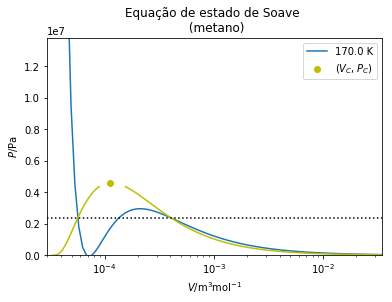

In [24]:
plt.plot(seqVm,seqP,label=str(Ttest)+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
plt.ylabel(r'$P / \mathrm{Pa}$') #create labels to be displayed in y axis of the plot
plt.xlabel(r'${V} / \mathrm{m^{3}mol^{-1}}$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Equação de estado de Soave \n (metano)') #create a title for the figure
plt.ylim(0,Pc*3)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
plt.xlim(b,(R*Tc/Pc)*100) #define max and min limits of the x axis
plt.xscale('log')

plt.plot(VL_seq,seqP3, color='y')
plt.plot(VV_seq,seqP3, color='y')


plt.axhline(Psat_test,color='black',ls=':')

plt.scatter(vc,Pc,color='y',label=r'$(V_{C},P_{C})$')
      
plt.legend()

plt.show()

# diagrama de fases no envelope P versus H

In [25]:
A1 = 1.702
B1 = 9.081*10**(-3)
C1 = -2.164*10**(-6)

def func_Hgi(T): #integral CpdT, considerando como temperatura de referência 298K
    T0 = 298.
    Hgi=R*(A1*(T-T0)+(B1/2)*(T**2-T0**2)+(C1/3)*(T**3-T0**3))
    return Hgi

#calculo de Hreal considerando como temperatura de referência 298K
def func_Hreal(T,P,Z):
    Hres=func_Hres(T=T,P=P,Z=Z)
    Hgi=func_Hgi(T=T)
    return Hres+Hgi

def func_dadT(T): #definição de da/dT
    Tr = T/Tc
    dadT = (-0.45724*(R*Tc)**2/Pc)*f_omega*((1+f_omega*(1-Tr**.5))**2/(Tc*T))**.5  
    return dadT

def func_Hres(T,P,Z): #definição de Hres (A=U-TS; H=U+PV :. H=A+PV+TS)
    B=(b*P)/(R*T)
    a=func_a(T=T)
    dadT=func_dadT(T=T)    
    T1=np.sqrt(u**2-4*w)    
    Hres = ((a-T*dadT)/(b*T1))*np.log( (2*Z+B*(u-T1))/(2*Z+B*(u+T1)) ) + R*T*(Z-1)
    return Hres

In [27]:
#CALCULAR H PARA CADA TSAT/PSAT/VSATL E TSAT/PSAT/VSATV

HL_seq=np.zeros(nPsat)
HV_seq=np.zeros(nPsat)
for i in range(nPsat):
    VL,VV,nV=func_VL_VV_cubic(T=seqT3[i],P=seqP3[i])
    ZL=seqP3[i]*VL/(R*seqT3[i])
    ZV=seqP3[i]*VV/(R*seqT3[i])
    HL_seq[i]=func_Hreal(T=seqT3[i],P=seqP3[i],Z=ZL)
    HV_seq[i]=func_Hreal(T=seqT3[i],P=seqP3[i],Z=ZV)

In [28]:
#CALCULAR H PARA seqV DADO T
nV=1000
seq_V= np.logspace(np.log10(b*1.01),2+np.log10(R*Tc/Pc),nV)
seq_P=np.zeros(nV)
seq_H=np.zeros(nV)
Z=np.zeros(nV)
for i in range(nV):
    seq_P[i]= func_P_soave(Ttest,seq_V[i])
    Z[i]=(seq_P[i]*seq_V[i])/(R*Ttest)
    seq_H[i]=func_Hreal(T=Ttest,P=seq_P[i],Z=Z[i])

In [28]:
Hrealc=func_Hreal(T=Tc,P=Pc,Z=Pc*vc/(R*Tc))

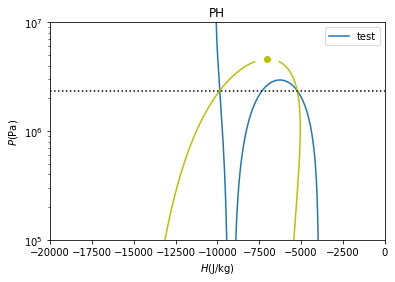

In [29]:
plt.plot(seq_H,seq_P,label='test')
plt.yscale('log')
plt.ylabel(r'$P (\mathrm{Pa})$')
plt.xlabel(r'${H} (\mathrm{J/Kg)}})$')

plt.plot(HL_seq,seqP3, color='y')
plt.plot(HV_seq,seqP3, color='y')
plt.yscale('log')
plt.ylabel(r'$P (\mathrm{Pa})$')
plt.xlabel(r'${H} (\mathrm{J/kg})$')
plt.title('PH')
plt.xlim(-20000,0)
plt.ylim(1e5,1e7)

plt.scatter(Hrealc,Pc, color='y')
plt.axhline(Psat_test,color='black',ls=':')
plt.legend()
plt.show()

In [30]:
def func_Sres(T,P,Z): #cálculo da S residual
    B=b*P/(R*T)
    dadT=func_dadT(T=T)
    T1=np.sqrt(u**2-4*w)
    Sres = R*np.log(Z-B) - (dadT/(b*T1))*np.log( (2*Z+B*(u-T1))/(2*Z+B*(u+T1)) )
    return Sres

def func_Sgi(T,P): #cálculo da S gas ideal usando integral Cp/T dT e ln(P/P0)
    #considerando como temperatura de referência 298K e pressao de referencia 1 bar
    T0=298. #K
    P0=1e5 #Pa
    Sgi=R*(A1*np.log(T/T0)+B1*(T-T0)+(C1/2)*(T**2-T0**2)) - R*np.log(P/P0)
    return Sgi

def func_Sreal(T,P,Z):
    #considerando como temperatura de referência 298K e pressao de referencia 1 bar
    Sgi = func_Sgi(T=T,P=P)
    Sres = func_Sres(T=T,P=P,Z=Z)
    Sreal = Sres+Sgi
    return Sreal

In [31]:
#Cálculo de T através de Van der Waals
from scipy.optimize import fsolve

  
def func_T_Soave(P,Vm):
    from scipy.optimize import fsolve
    
    def T_guess(P,Vm):
        a=func_a(T=Tc)
        return (P + a/(Vm**2 + u*b*Vm + w*b**2) )*(Vm-b)/R

    def RES(T):
        return P-func_P_soave(T=T,Vm=Vm)

    T=fsolve(func=RES,x0=T_guess(P=P,Vm=max(Vm,b*1.01)))[0]

    return T

Vmtest=5e-5
Ptest=func_P_soave(T=230,Vm=Vmtest)
print(Ptest)
print( func_T_Soave(P=Ptest,Vm=Vmtest) )


42057993.35180766
229.99999999999997


In [32]:
# envelope
#CALCULAR S PARA CADA TSAT/PSAT/VSATL E TSAT/PSAT/VSATV
SL_seq=np.zeros(nPsat)
SV_seq=np.zeros(nPsat)
for i in range(nPsat):
    VL,VV,nV=func_VL_VV_cubic(T=seqT3[i],P=seqP3[i])
    ZL=seqP3[i]*VL/(R*seqT3[i])
    ZV=seqP3[i]*VV/(R*seqT3[i])
    SL_seq[i]=func_Sreal(T=seqT3[i],P=seqP3[i],Z=ZL)
    SV_seq[i]=func_Sreal(T=seqT3[i],P=seqP3[i],Z=ZV)

In [33]:
# isobaras

Ptest=Psat_test
nV=1000
val_V= np.logspace(np.log10(1.01*b),2+np.log10(R*Tc/Pc),nV) #valores de pressão estipulados

seq_T=np.zeros(nV)
seq_S=np.zeros(nV)
Z=np.zeros(nV)

for i in range(nV): #para cada volume terá um valor de T e um de S
    seq_T[i]= func_T_Soave(P=Ptest,Vm=seq_V[i])
    Z[i]=(Ptest*seq_V[i])/(R*seq_T[i])
    seq_S[i]=func_Sreal(T=seq_T[i],P=Ptest,Z=Z[i])

In [34]:
Srealc=func_Sreal(T=Tc,P=Pc,Z=Pc*vc/(R*Tc))

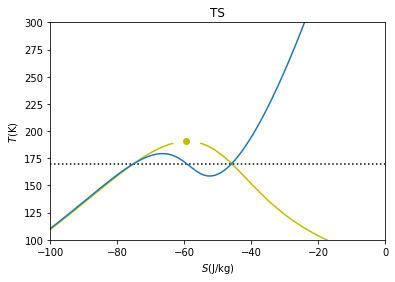

In [35]:
plt.plot(SL_seq,seqT3, color='y')
plt.plot(SV_seq,seqT3, color='y')
plt.ylabel(r'$T (\mathrm{K})$') 
plt.xlabel(r'${S} (\mathrm{J/kg})$')
plt.title('TS')
plt.xlim(-120,0)
plt.ylim(100,250)
plt.scatter(Srealc,Tc, color='y')
plt.axhline(Ttest,color='black',ls=':')
#isobara
plt.plot(seq_S,seq_T)    
plt.show()


# Conclusão

A solução do equilibrio liquido vapor por eos não é simples. há que se preocupar com solução trivial (GresL=GresV | vl=vv; eos retornando uma unica raiz real; dificuldade de convergencia dos metodo numericos...)



# Referências

>* Reid, R. C., Prausnitz, J. M. and Poling, B. E., 1987. The Properties of Gases and Liquids. 4th ed., McGraw-Hill. [ISBN: 0070517991, 9780070517998
](https://books.google.com.br/books?id=AcRTAAAAMAAJ)

>* Smith, J. M., van Ness, H. C. and Abbott, M. M., 2007. Introdução a termodinâmica da engenharia química. 7a ed., LTC. [ISBN: 8521615531, 9788521615538](https://books.google.com.br/books?id=TzeQPgAACAAJ)


>* Topliss, R J., Dimitrelis D., and Prausnitz, J. M., 1988, “Computational Aspects of a Non-Cubic Equation of State for Phase-Equilibrium Calculations. Effect of Density-Dependent Mixing Rules.” Computers & Chemical Engineering 12 (5): 483–89. [doi:10.1016/0098-1354(88)85067-1](http://dx.doi.org/10.1016/0098-1354(88)85067-1)

>* [numpy.roots ](https://docs.scipy.org/doc/numpy/reference/generated/numpy.roots.html)
>* [scipy.optimize.bisect](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html)
>* [scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)